# Detection 

In [13]:
import requests

url = "http://localhost:8000/detect"
image_path = "../resources/images/4.jpg"


with open(image_path, "rb") as f:
    files = {"file": (image_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

if response.status_code == 200:
    result = response.json()
    print("Обнаруженные боксы:")
    for box in result["boxes"]:
        print(box)
else:
    print("Ошибка:", response.status_code, response.text)


Обнаруженные боксы:
{'x1': 183, 'y1': 63, 'x2': 471, 'y2': 230}


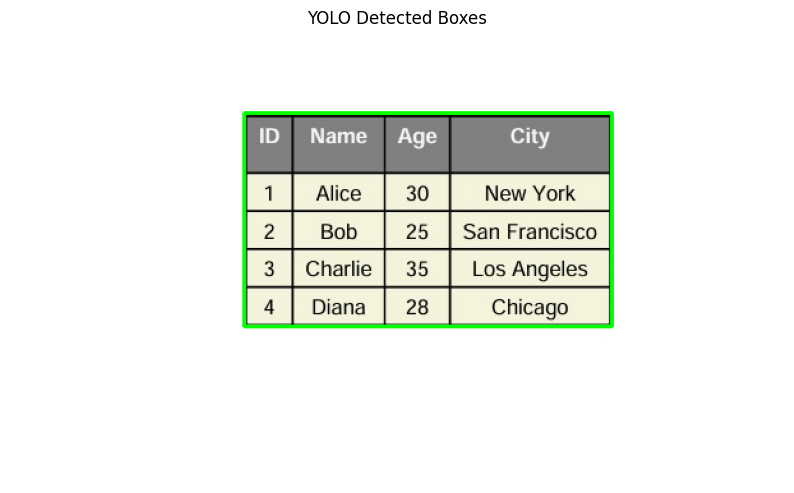

In [16]:
import requests
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

image_path = "../resources/images/4.jpg"
url = "http://localhost:8000/detect"

with open(image_path, "rb") as f:
    files = {"file": (image_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

result = response.json()
boxes = result.get("boxes", [])

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for box in boxes:
    x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("YOLO Detected Boxes")
plt.axis("off")
plt.show()

# Service Usage

In [24]:
import requests
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import pandas as pd

# Пути и настройки
image_path = "../resources/images/4.jpg"
detect_url = "http://localhost:8000/detect"
recognize_url = "http://localhost:8001/recognize"

image = cv2.imread(image_path)

with open(image_path, "rb") as f:
    files = {"file": (image_path, f, "image/jpeg")}
    detect_response = requests.post(detect_url, files=files)

detect_response.raise_for_status()
boxes = detect_response.json()["boxes"]

results = []
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

    # Вырезаем ROI и кодируем в память
    roi = image[y1:y2, x1:x2]
    is_success, buffer = cv2.imencode(".jpg", roi)
    if not is_success:
        print(f"Ошибка при кодировании ROI {i}")
        continue

    roi_bytes = BytesIO(buffer.tobytes())

    files = {"file": ("cell.jpg", roi_bytes, "image/jpeg")}
    rec_response = requests.post(recognize_url, files=files)

    if rec_response.status_code == 200:
        data = rec_response.json()
        results.append(data.get("table", []))
    else:
        results.append(f"[Ошибка OCR: {rec_response.status_code}]")

pd.DataFrame(data["table"])


,0,1,2,3
0,1,Alice,30,New York
1,2,Bob,25,San Francisco
2,3,Charlie,35,Los Angeles
3,4,Diana,28,Chicago
